# Linear Kalman Filter

## 問題

だいたい一定速度で走行する自動車の距離をセンサで計測するとき，自動車の位置と速度を推定する．

## 考え方

推定する状態を $[x_t, v_t]$ とする．
システムに対する入力を $a_t$ として，状態方程式を立てる．
※ 加速度は，位置や速度と微分積分の関係にあるので，物理的な拘束式を立式できそうですね．

ほぼ一定で走行しているので，入力となる加速度は $0$ で良さそうです．
ただしは誤差はのるので，こちらはカルマンフィルタの制約に従ってガウス分布でモデル化します．

## 状態方程式

$$
\left[\begin{array}{c}
    x_t \\
    v_t \\
\end{array}\right]
=
\left[\begin{array}{c}
    1 & \tau \\
    0 & 1 \\
\end{array}\right]
\left[\begin{array}{c}
    x_{t-1} \\
    v_{t-1} \\
\end{array}\right]
+
\left[\begin{array}{c}
    \frac{\tau^2}{2} \\
    \tau \\
\end{array}\right]
a_{t-1}
$$

ここで，$F$，$G$ は
$F=
\left[\begin{array}{c}
    1 & \tau \\
    0 & 1 \\
\end{array}\right]$
，
$G=
\left[\begin{array}{c}
    \frac{\tau^2}{2} \\
    \tau \\
\end{array}\right]$
となります．

# 観測方程式

$$
z_t
=
\left[\begin{array}{c}
    1 & 0
\end{array}\right]
\left[\begin{array}{c}
    x_{t} \\
    v_{t} \\
\end{array}\right]
+
\Delta z_t
$$

ここで，$H$ は
$H=
\left[\begin{array}{c}
    1 & 0
\end{array}\right]$
となります．

# 初期値
$x_0=0$ [m]，$v_0=10$ [m/s]，入力分散 $Q=0.4$ [m^2/s^6]，観測分散 $R=9$ [m^2]， 演算周期 $\tau=0.010$ [s]

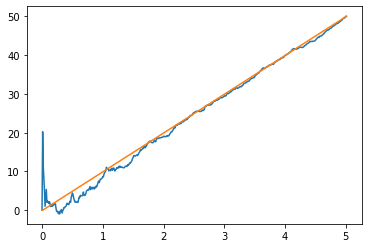

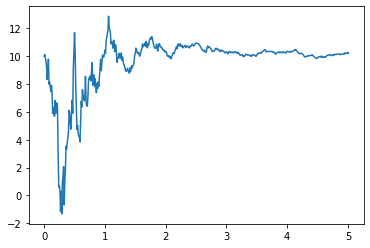

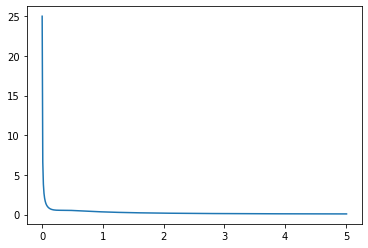

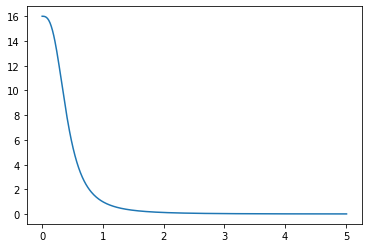

In [111]:
import numpy as np
import matplotlib.pyplot as plt

# =========================================================
#* Settings *#
# =========================================================

# シミュレーションの設定
sim_t_limit = 5
tau = 0.010

# 状態方程式: 変数設定
x = np.array([0, 10]).reshape(2, 1)

F = np.array([[1, tau],
              [0, 1]])
G = np.array([tau**2/2, tau]).reshape(2, 1)
P = np.array([[25, 0],
              [0, 16]])
Q = 1

# 観測方程式: 変数設定
H = np.array([1, 0])
R = 9


# =========================================================
#* Simulation *#
# =========================================================

t = 0
t_list = [0]
true_pos_list = [0]
pos_list = [x[0, 0]]
vel_list = [x[1, 0]]
pos_var_list = [P[0, 0]]
vel_var_list = [P[1, 1]]

while (t < sim_t_limit):
    #* 予測ステップ *#
    x = np.matmul(F, x) + G * np.random.normal(loc=0, scale=Q)
    P = np.matmul(np.matmul(F, P), F.T) + np.matmul(G*Q, G.T)

    
    #* 計測更新ステップ *#
    # センサによる観測
    true_x = 10 * t
    sens_z = true_x + np.random.normal(loc=0, scale=R)
    
    # 観測予測誤差
    tilde_z = sens_z - np.matmul(H, x)
    
    # 観測予測誤差分散
    S = np.matmul(np.matmul(H, P), H.T) + R
    
    # カルマンゲイン
    K = np.matmul(P, H) / S
    K = K.reshape(2, 1)

    # 状態更新
    x = x + K*tilde_z
    P = P - np.matmul(K*S, K.T)

    # シミュレーション時間更新
    t += tau
    
    t_list.append(t)
    true_pos_list.append(true_x)
    pos_list.append(x[0, 0])
    vel_list.append(x[1, 0])
    pos_var_list.append(P[0, 0])
    vel_var_list.append(P[1, 1])


#* プロット *#

# 距離
plt.plot(t_list, pos_list)
plt.plot(t_list, true_pos_list)
plt.figure()

# 速度
plt.plot(t_list, vel_list)
plt.figure()

# 距離 分散
plt.plot(t_list, pos_var_list)
plt.figure()

# 速度 分散
plt.plot(t_list, vel_var_list)


位置・速度の分散が小さくなっていっているのが分かりますね．

カルマンフィルタによる推定位置・速度も，分散が小さくなるにつれて，誤差が小さくなっており，位置は真値に近づいているのが分かります．